<a href="https://colab.research.google.com/github/cbev/sedimentGEE/blob/master/SedimentANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
print('tf version (should be 2.1.0):',tf.__version__)
# import os, sys
# from google.colab import drive
# drive.mount('/content/mnt')
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

# !pip install --target=$nb_path  --upgrade tensorflow


tf version (should be 2.1.0): 2.1.0


fatal: destination path 'sedimentGEE' already exists and is not an empty directory.


In [0]:
from google.colab import files
uploaded = files.upload()
## upload df.csv
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

Saving comp_set_2day.csv to comp_set_2day.csv


In [0]:
# Import the data and convert to values

import io
import numpy as np
df = pd.read_csv(io.BytesIO(uploaded['comp_set_2day.csv'])) # if it's the first time uploading

df = pd.read_csv('comp_set_2day.csv')
df.drop(labels='Unnamed: 0',axis=1, inplace=True)
df.LID=df.LID.astype(int)

# Define which monitoring points:  BD=1, HB=2, BA=3, MW=4);
df=df[df['station'].isin([3, 4])]
df=df.drop(labels=['station'],axis=1)

# Define which satellite(s) to get data from- uncomment option: 2=Sentinel-2; 3=MODIS; 5, 7, 8= Landsat 5, 7, 8
df=df[df['LID'].isin([2, 8])] 
df=df.drop(labels=['LID','total'],axis=1)
#df=df[['LID','blue','nir','red','gn','sp1','obs_mgL','month']]
#df=df[['LID','rb','rn','rg','red','gn','sp1','obs_mgL','month']]

#df=df[df['LID'].isin([5, 7])] 
#df=df.drop(labels=['LID'],axis=1)
#df=df[['blue','green','nir','sp1','obs_mgL','month']]

# df=df[df['LID'].isin([3])] 
#df=df.drop(labels=['LID'],axis=1)
# df=df[['blue','nir','red','obs_mgL','month']]

df.reset_index(inplace=True, drop=True)
df_prescaled = df.copy() # save a prescaled matrix
print(df.head())

    blue   green     nir      obs_mgL    red        rb        rg        rn  \
0  0.096  0.1380  0.1160  1057.313978  0.148  1.541667  1.072464  1.275862   
1  0.098  0.1170  0.0650  191.340171   0.089  0.908163  0.760684  1.369231   
2  0.074  0.0920  0.0400  191.463036   0.067  0.905405  0.728261  1.675000   
3  0.080  0.1285  0.0735  932.555485   0.137  1.712500  1.066148  1.863946   
4  0.087  0.1190  0.0600  831.943413   0.118  1.356322  0.991597  1.966667   

         gn      sp1       sp2  month  
0  1.189655  0.14300  1.188464  8      
1  1.800000  0.10300  0.825684  2      
2  2.300000  0.07950  0.768261  3      
3  1.748299  0.13275  1.139648  9      
4  1.983333  0.11850  1.051597  10     


11


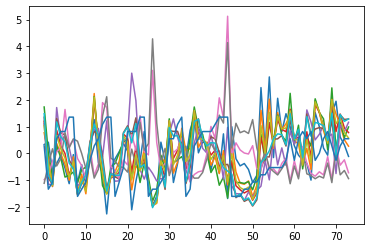

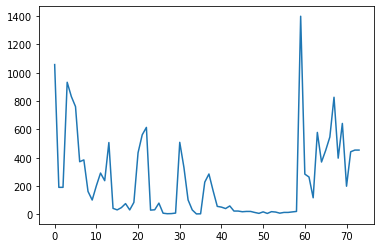

In [0]:
scale='yes'
cca='no'

if scale=='yes':
  from sklearn.preprocessing import scale

  df_scaled = df.drop(['obs_mgL'], axis=1)
  df_scaled = scale(df_scaled)
  cols = df.columns.tolist()
  cols.remove('obs_mgL')
  df_scaled = pd.DataFrame(df_scaled, columns=cols, index=df.index)
  df_scaled = pd.concat([df_scaled, df['obs_mgL']], axis=1)
  df = df_scaled.copy()

# define input and output
X=df.drop(labels=['obs_mgL'],axis=1).values
y=df.obs_mgL.values


if cca=='yes':
  from sklearn.cross_decomposition import CCA
  cca = CCA(n_components=1)
  cca.fit(X, y)
  #CCA(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)
  X,y = cca.transform(X, y)

import matplotlib.pyplot as plt
plt.plot(X)
plt.figure()
plt.plot(y)
print(X.shape[1])

23/23 [==============================] - 0s 4ms/sample - loss: 28380.4355 - mse: 28380.4355
0
23/23 [==============================] - 0s 4ms/sample - loss: 145823.0156 - mse: 145823.0156
1
23/23 [==============================] - 0s 4ms/sample - loss: 44271.5938 - mse: 44271.5938
2
23/23 [==============================] - 0s 4ms/sample - loss: 78722.2031 - mse: 78722.2031
3
23/23 [==============================] - 0s 4ms/sample - loss: 34114.5273 - mse: 34114.5273
4
23/23 [==============================] - 0s 4ms/sample - loss: 129002.8672 - mse: 129002.8672
5
23/23 [==============================] - 0s 4ms/sample - loss: 32441.6855 - mse: 32441.6855
6
23/23 [==============================] - 0s 4ms/sample - loss: 37552.7617 - mse: 37552.7617
7
23/23 [==============================] - 0s 4ms/sample - loss: 30556.5137 - mse: 30556.5137
8
23/23 [==============================] - 0s 4ms/sample - loss: 60812.9844 - mse: 60812.9844
9
23/23 [==============================] - 0s 4ms/sample -

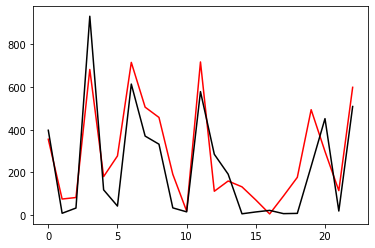

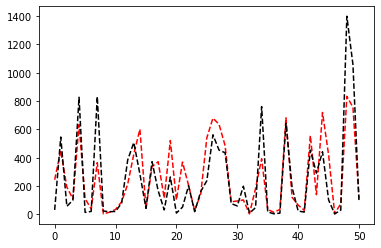

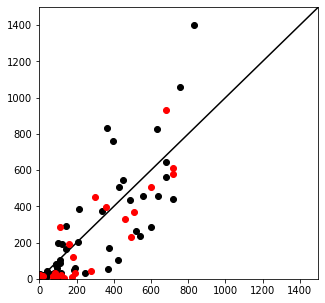

In [0]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics

def model_base(input_dim):
  # define the keras model
  # Deep layer since a complex problem
  # add layers to the model- for each layers, define number of units and the activation function
  # use "relu' activation function to introduce non-linearity into the mode

  model = Sequential() # define type of model
  model.add(Dense(units=32, input_dim=input_dim, activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(16, activation= 'relu')) # hidden layer 1
  model.add(Dense(16, activation= 'relu')) # hidden layer 2
  model.add(Dense(8, activation= 'relu')) # hidden layer 3
  model.add(Dense(8, activation= 'relu')) # hidden layer 4
  model.add(Dense(8, activation= 'relu')) # hidden layer 5
  model.add(Dense(8, activation= 'relu')) # hidden layer 6
  model.add(Dense(8, activation= 'relu')) # hidden layer 7
  model.add(Dense(4, activation= 'relu')) # hidden layer 8
  model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse']);

  return model

def run_ann(iterations, batch_size, epochs, test_size):
   # Split into training and testing data
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size)

  # develop the base model
  model=model_base(X_train.shape[1])

  # Define the first parameters as the "top"
  X_train_top=X_train
  y_train_top=y_train
  X_test_top=X_test
  y_test_top=y_test

  # train and evaluate the model
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False);
  _, accuracy_top = model.evaluate(X_test, y_test) # evaluate based on the "testing" performance
  weights_top = model.get_weights()

  for i in range (0,iterations-1):
    print(i)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = test_size) 
    model=model_base(X_train.shape[1])
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False);
    _, accuracy_i = model.evaluate(X_test, y_test); # evaluate based on the "testing" performance
    #_, accuracy_i = model.evaluate(X_train, y_train); # evaluate based on the "training" performance
    #_, accuracy_i = model.evaluate(np.concatenate([X_test, X_train]), np.concatenate([y_test, y_train])); # evaluate based on the overall performance
    weights_i = model.get_weights()

    if accuracy_i<accuracy_top:
      weights_top=weights_i;
      accuracy_top=accuracy_i;
      X_train_top=X_train
      y_train_top=y_train
      X_test_top=X_test
      y_test_top=y_test

    
  return weights_top, accuracy_top, X_train_top, y_train_top, X_test_top, y_test_top


weights, accuracy, X_train, y_train, X_test, y_test= run_ann(50, 10, 300, 0.3)

# Set the model with the top weights
model=model_base(X_train.shape[1])
model.set_weights(weights)

#import matplotlib.pyplot as plt
plt.plot(model.predict(X_test),'r')
plt.plot(y_test,'k')
_, accuracy = model.evaluate(X_test, y_test);
print('Test Accuracy: %.2f' % (np.sqrt(accuracy)));
plt.figure()
plt.plot(model.predict(X_train),'r--');
plt.plot(y_train,'k--')
_, accuracy = model.evaluate(X_train, y_train);
print('Train Accuracy: %.2f' % (np.sqrt(accuracy)))

xmax=1500
ymax=1500

plt.figure(figsize=(5,5))
plt.plot([0,xmax], [0, xmax],'k-')
plt.plot(model.predict(X_train), y_train,'ko')
plt.plot(model.predict(X_test), y_test,'ro')

axes = plt.gca()
axes.set_xlim([0,xmax])
axes.set_ylim([0,ymax])

r2_train = metrics.r2_score(y_train, model.predict(X_train));
r2_test = metrics.r2_score(y_test, model.predict(X_test));
r2_total = metrics.r2_score(np.concatenate([y_train, y_test]), np.concatenate([model.predict(X_train), model.predict(X_test)]));
print ('r2, train', r2_train)
print ('r2, test', r2_test)
print ('r2, total', r2_total)


23/23 [==============================] - 0s 4ms/sample - loss: 19500.1543 - mse: 19500.1543
Test Accuracy: 139.64
51/51 [==============================] - 0s 159us/sample - loss: 34146.5444 - mse: 34146.5430
Train Accuracy: 184.79
r2, train 0.6203493377334122
r2, test 0.7262286797055006
r2, total 0.6483595872166044


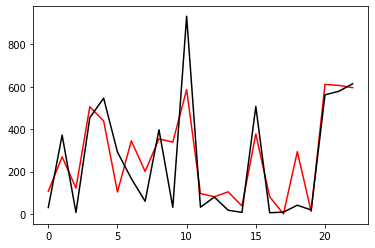

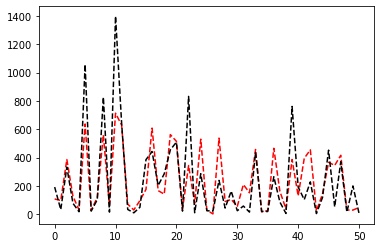

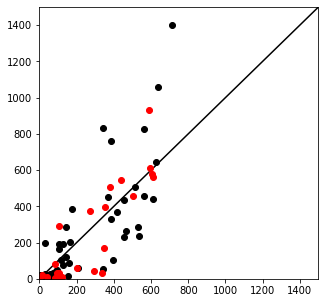

In [0]:
model=model_base(X_train.shape[1])
model.set_weights(weights)

plt.plot(model.predict(X_test),'r')
plt.plot(y_test,'k')
_, accuracy = model.evaluate(X_test, y_test);
print('Test Accuracy: %.2f' % (np.sqrt(accuracy)));
plt.figure()
plt.plot(model.predict(X_train),'r--');
plt.plot(y_train,'k--')
_, accuracy = model.evaluate(X_train, y_train);
print('Train Accuracy: %.2f' % (np.sqrt(accuracy)))

xmax=1500
ymax=1500

plt.figure(figsize=(5,5))
plt.plot([0,xmax], [0, xmax],'k-')
plt.plot(model.predict(X_train), y_train,'ko')
plt.plot(model.predict(X_test), y_test,'ro')

axes = plt.gca()
axes.set_xlim([0,xmax])
axes.set_ylim([0,ymax])

r2_train = metrics.r2_score(y_train, model.predict(X_train));
r2_test = metrics.r2_score(y_test, model.predict(X_test));
r2_total = metrics.r2_score(np.concatenate([y_train, y_test]), np.concatenate([model.predict(X_train), model.predict(X_test)]));
print ('r2, train', r2_train)
print ('r2, test', r2_test)
print ('r2, total', r2_total)

In [0]:
# using cross function

from tensorflow.python.keras.layers import Dense

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def baseline_model():    
 # define the keras model
  model = Sequential() # define type of model
  # Deep layer since a complex problem
  # add layers to the model- for each layers, define number of units and the activation function
  # use "relu' activation function to introduce non-linearity into the mode; use 'elu' since will take exponential into account
  model.add(Dense(units=X_train.shape[1], input_dim=X_train.shape[1], activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(units=1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model

def large_model():    
 # define the keras model
  model = Sequential() # define type of model
  model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  model.add(Dense(64, activation= 'relu')) # each successive node has hald the layers of predecessor
  model.add(Dense(32, activation= 'relu'))
  model.add(Dense(8, activation= 'relu'))
  model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  return model  

# model = KerasRegressor(build_fn=baseline_model, epochs=500, verbose=0)
# # evaluate using 10-fold cross validation
# kfold = KFold(n_splits=10)
# results = cross_val_score(model, X, y, cv=kfold)
# print(results.mean())


estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=500, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -84289.25 (148219.73) MSE


In [0]:
# Shallow model  
  
  #model.add(Dense(units=1, input_dim=X_train.shape[1], activation='elu')) # first layer, have to define "input dim"- automatically set as the number of columns in X (the input)
  #model.add(Dense(6, activation= 'elu')) # each successive node has hald the layers of predecessor
  #model.add(Dense(1)) # since this is a regression problem, only one node in the ouput layers


In [0]:
from google.colab import files

In [0]:
!cwd

/bin/bash: cwd: command not found
